In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *

In [2]:
n_samples = 200
n_features_bytype = 4
n_features_multiplier = 3 

In [3]:
beta_features = np.concatenate([weights_sparse_exp(n_features_bytype,3),weights_sparse_exp(n_features_bytype,3),
                       weights_sparse_exp(n_features_bytype,3)])
treatment_effect = 0

In [4]:
control, treated, types = simulation(beta_features, treatment_effect , n_samples)
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [5]:
control.head()

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
2,-2.329837,-0.177992,-0.633925,-0.350214,0.596037,0.089699,0.927206,2.160913,0.0,0.0,1.0,1.0,0.526405,1
4,-0.530011,-1.167549,-1.360785,-0.797203,0.588755,0.044592,0.891551,0.398400,0.0,0.0,1.0,1.0,1.478748,0
6,-0.328991,0.892380,0.580651,0.985074,0.317152,0.319077,1.181943,1.404921,1.0,1.0,1.0,1.0,0.647505,0
7,-1.131817,-0.104563,-0.437335,1.249596,1.604752,0.021993,0.764246,0.896973,1.0,1.0,1.0,1.0,1.553416,1
10,0.687976,-0.450278,-0.287709,0.435015,0.190714,0.554372,0.339351,1.202735,0.0,0.0,0.0,0.0,0.105668,1


In [6]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

In [7]:
control.to_csv(data_file_control,index=False , header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated,index=False , header=False)
types.to_csv(feat_types_file_treated)

## Compute expected power / level via Schoenfeld formula

$$D = \frac{(\Phi^{-1}(\beta)+\Phi^{-1}(1-\alpha))^2}{P_{cont}(1 - P_{cont}) log^2(\Delta)}$$
where 
- $D$ is the number of deaths
- $\alpha$ is the level
- $\beta$ is the power
- $P_{cont}$ is the proportion of patients in the control arm
- $\Delta$ is the hazard ratio

In [8]:
data = pd.concat([control,treated],ignore_index=True)
T = data['time']
C = data['censor']
D = np.sum(T <= C)

In [9]:
alpha = 0.05
p_treated = 0.5
expected_power = norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha))

In [10]:
expected_power

np.float64(0.05000000000000007)

## Generation

In [11]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                         miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [12]:
data_init_control_encoded

tensor([[-2.3298, -0.1780, -0.6339,  ...,  1.0000,  0.5264,  1.0000],
        [-0.5300, -1.1675, -1.3608,  ...,  1.0000,  1.4787,  0.0000],
        [-0.3290,  0.8924,  0.5807,  ...,  1.0000,  0.6475,  0.0000],
        ...,
        [-0.1259, -0.1567, -1.5192,  ...,  0.0000,  0.4699,  1.0000],
        [ 0.4403,  0.6102, -0.0182,  ...,  1.0000,  1.2279,  1.0000],
        [ 0.7156,  0.3158,  0.5782,  ...,  0.0000,  2.3914,  0.0000]])

In [13]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [14]:
feat_types_dict

[{'': '0', 'name': 'feat1', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '1', 'name': 'feat2', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '2', 'name': 'feat3', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '3', 'name': 'feat4', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '4', 'name': 'feat5', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '5', 'name': 'feat6', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '6', 'name': 'feat7', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '7', 'name': 'feat8', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '8', 'name': 'feat9', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '9', 'name': 'feat10', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '10', 'name': 'feat11', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '11', 'name': 'feat12', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '12',
  'name': 'survcens',
  'type': 'surv_piecewise',
  'dim': '2',
  'nclass': ''}]

In [15]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

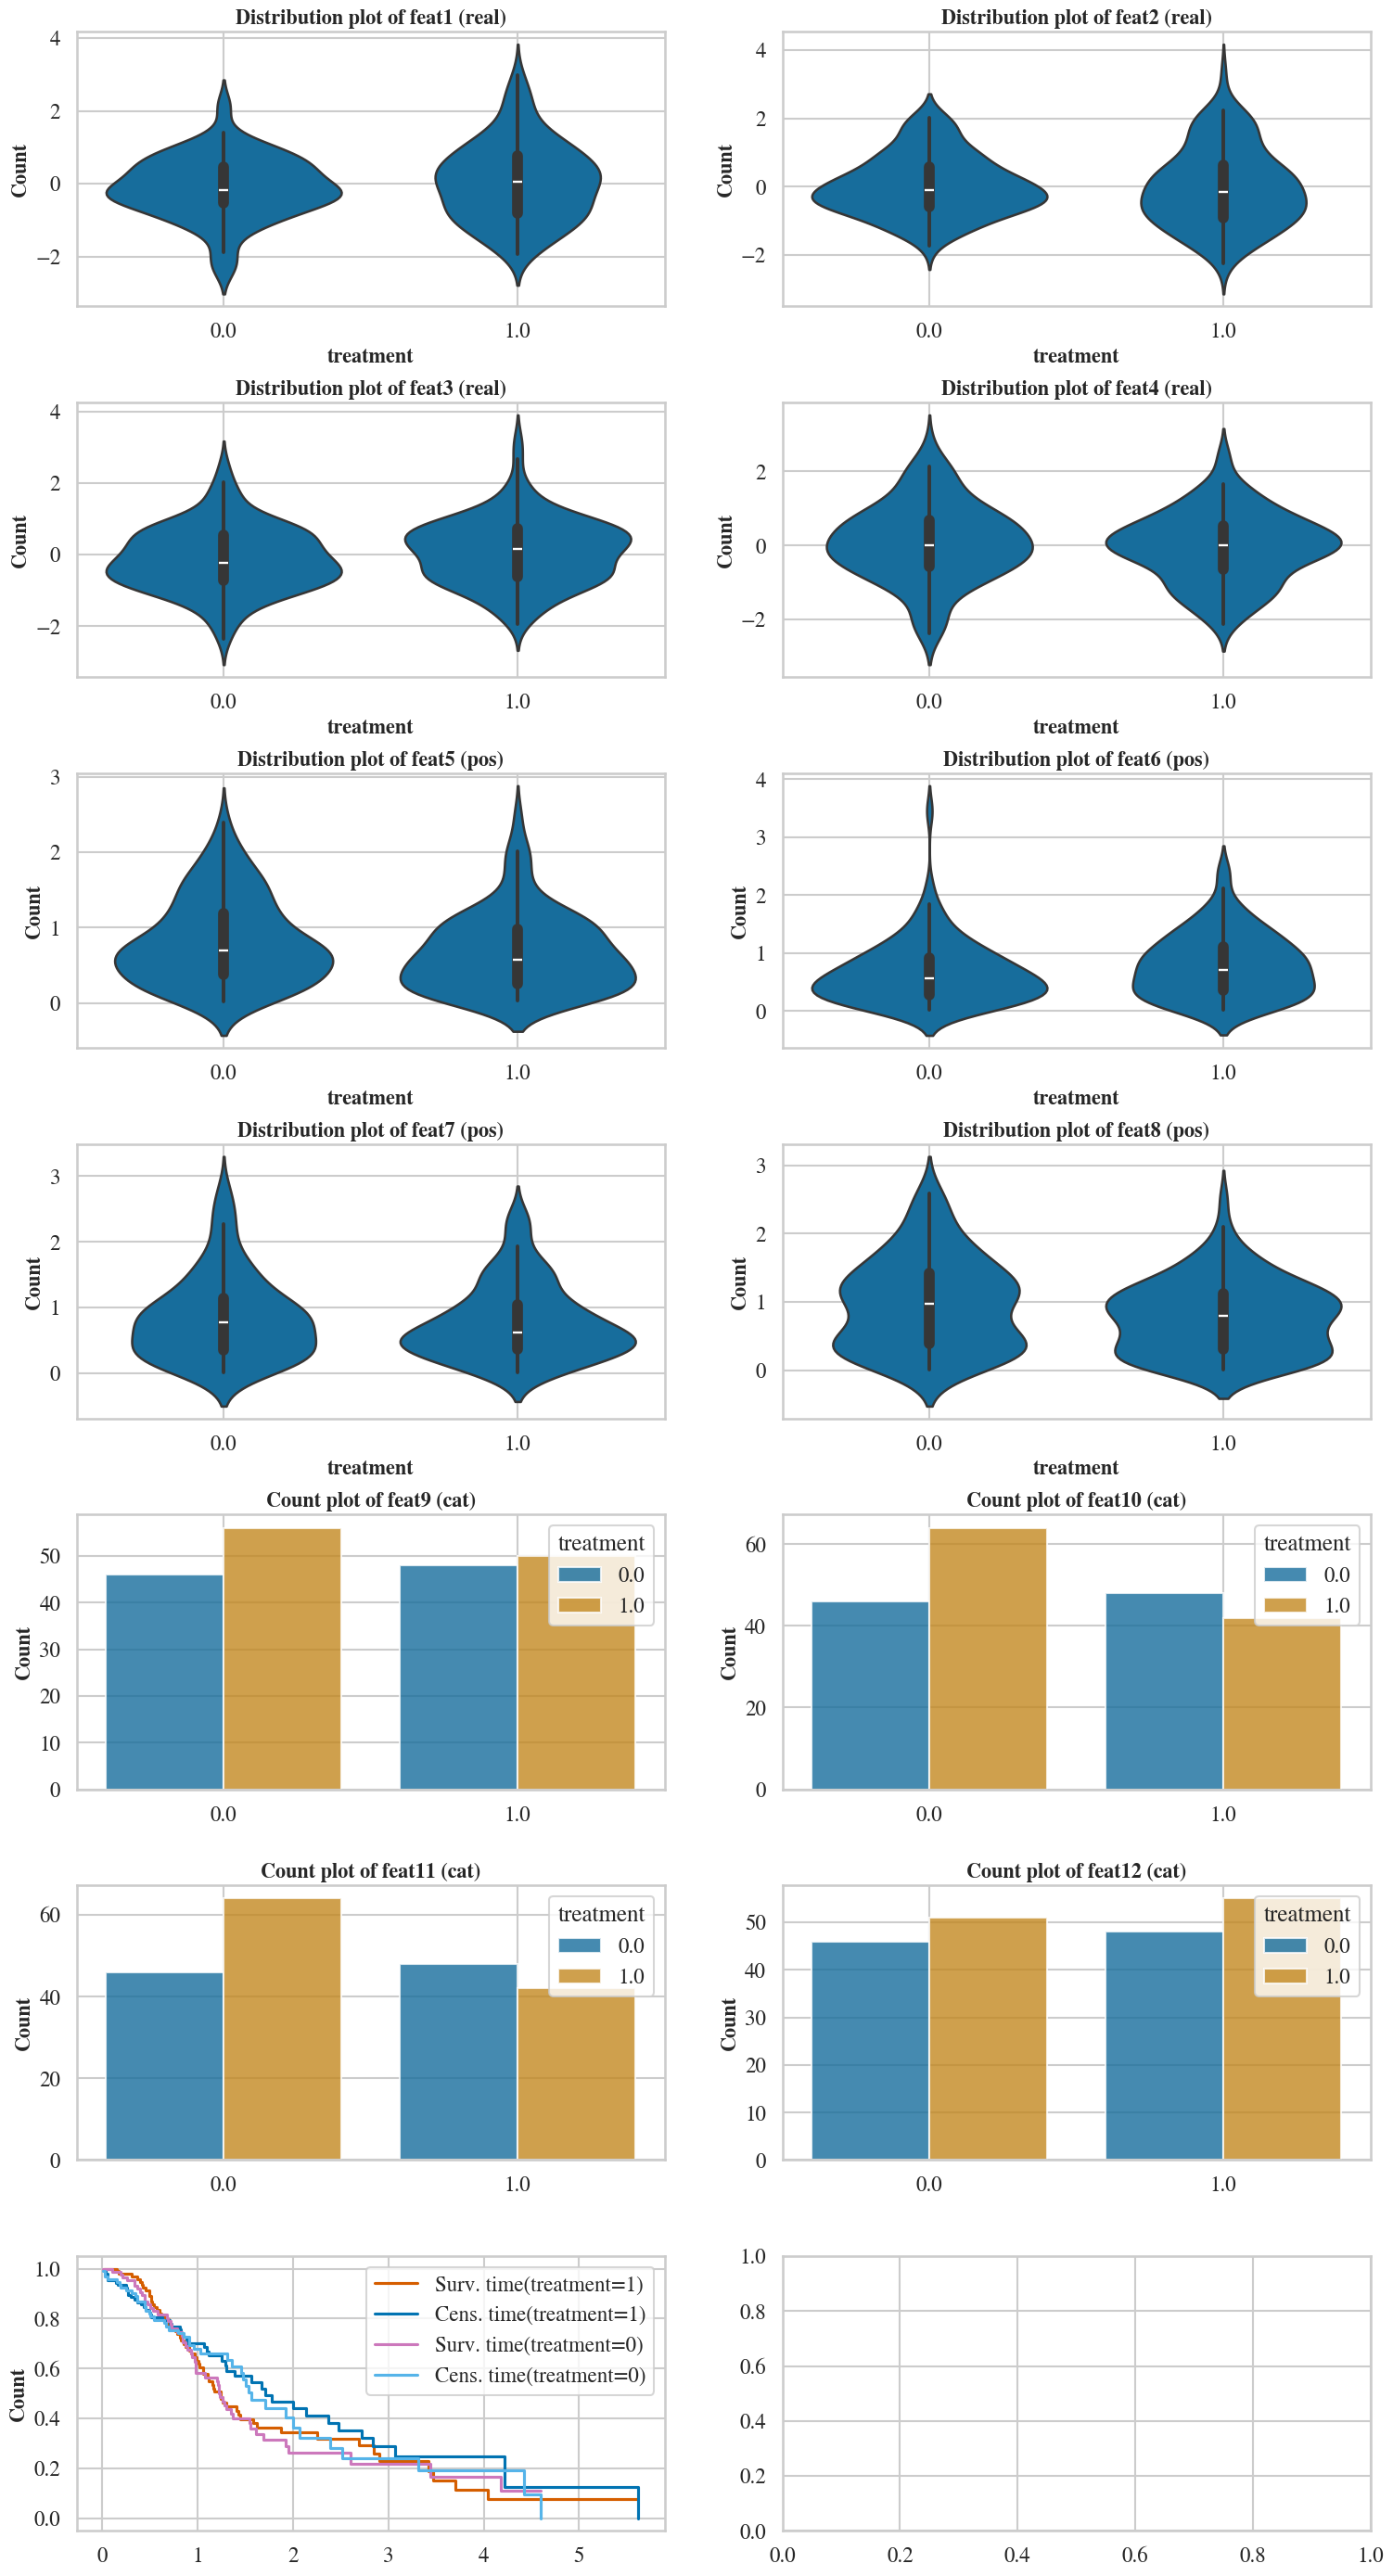

In [16]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [17]:
names_cont = []
names_pos = []
names_cat = []
for x in range(1, n_features_bytype   + 1):
            names_pos.append("feat{0}".format(x + n_features_bytype))
            names_cat.append("feat{0}".format(x + 2 * n_features_bytype))

table1 = TableOne(df_init, categorical=names_cat, continuous=names_cont, 
                  groupby='treatment', nonnormal=names_pos, pval=True)
print(table1)

                          Grouped by treatment                                                     
                                       Missing        Overall              0              1 P-Value
n                                                         200             94            106        
feat1, mean (SD)                             0     -0.0 (1.0)     -0.1 (0.8)      0.1 (1.1)   0.232
feat2, mean (SD)                             0      0.0 (1.0)      0.0 (0.9)     -0.0 (1.1)   0.767
feat3, mean (SD)                             0     -0.0 (0.9)     -0.1 (0.9)      0.1 (0.9)   0.105
feat4, mean (SD)                             0      0.0 (1.0)      0.1 (1.0)     -0.1 (0.9)   0.338
feat5, median [Q1,Q3]                        0  0.6 [0.3,1.1]  0.7 [0.4,1.2]  0.6 [0.3,1.0]   0.054
feat6, median [Q1,Q3]                        0  0.6 [0.3,1.0]  0.6 [0.3,0.9]  0.7 [0.3,1.1]   0.066
feat7, median [Q1,Q3]                        0  0.7 [0.4,1.1]  0.8 [0.4,1.1]  0.6 [0.4,1.0]   0.550


In [18]:
from execute import surv_hivae

# the datasets used for training is data_init_control
n_generated_sample = 10
T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 5
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [19]:
data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                  true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_sample)

RuntimeError: torch.cat(): expected a non-empty list of Tensors

## Replication

In [ ]:
M = 100
log_p_value = []
for m in np.arange(M):
    control, treated = simulation(beta_features, treatment_effect , n_samples, data_types_create=False)
    log_p_value.append(compute_logrank_test(control, treated))

In [ ]:
np.mean(log_p_value >= -np.log(0.05))